In [1]:
# ! pip install lifetimes

In [2]:

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
def get_outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_outliers_with_thresholds(dataframe, variable):
    low_limit, up_limit = get_outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [4]:
df_ = pd.read_excel("../datasets/online_retail_II.xlsx", sheet_name="Year 2009-2010")


In [5]:
df = df_.copy()

df.shape

(525461, 8)

In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0000,10.3377,107.4241,-9600.0000,1.0000,3.0000,10.0000,19152.0000
Price,525461.0000,4.6888,146.1269,-53594.3600,1.2500,2.1000,4.2100,25111.0900
Customer ID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


In [8]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,13.5856,96.8407,1.0000,2.0000,5.0000,12.0000,19152.0000
Price,407664.0000,3.2944,34.7580,0.0010,1.2500,1.9500,3.7500,10953.5000
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [10]:
replace_outliers_with_thresholds(df, "Quantity")
replace_outliers_with_thresholds(df, "Price")

df["TotalPrice"] = df["Quantity"] * df["Price"]

today_date = df["InvoiceDate"].max().to_pydatetime() + dt.timedelta(days=2) # Set today's date to two days after the most recent date in the data set

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,11.9065,28.7251,1.0000,2.0000,5.0000,12.0000,358.5000
Price,407664.0000,3.0056,3.2506,0.0010,1.2500,1.9500,3.7500,36.9400
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000
TotalPrice,407664.0000,20.6630,52.1374,0.0010,4.9500,11.9000,19.5000,3925.5750


In [12]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0000,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom,83.4000
1,489434,79323P,PINK CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
2,489434,79323W,WHITE CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0000,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom,100.8000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0000,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom,30.0000


In [13]:
clv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days,
                                                         lambda date: date.dt.month.nunique()],   # number of months the customer had a purchase on
                                        'Invoice': lambda num: num.nunique(), # number of transactions per customer
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

clv_df.columns = clv_df.columns.droplevel(0)  
clv_df.columns = ['recency', 'T', 'frequency', 'num_of_transactions', 'monetary']
clv_df["monetary"] = clv_df["monetary"] / clv_df["num_of_transactions"]
#clv_df = clv_df[(clv_df["num_of_transactions"] > 1)] 

clv_df["recency"] = clv_df["recency"] / 30  # monthly
clv_df["T"] = clv_df["T"] / 30

In [14]:
clv_df.head()

,recency,T,frequency,num_of_transactions,monetary
Customer ID,,,,,
12346.0000,6.5333,12.0667,4,11,33.8964
12347.0000,1.2333,1.3667,2,2,661.6600
12348.0000,0.0000,2.5000,1,1,222.1600
12349.0000,6.0333,7.5333,3,3,765.0067
12351.0000,0.0000,0.4000,1,1,300.9300


In [15]:
clv_df[['monetary', 'frequency']].corr() # No correlation between monetary and frequency?

,monetary,frequency
monetary,1.0000,0.1105
frequency,0.1105,1.0000


In [16]:
bgf = BetaGeoFitter(penalizer_coef=0.01)

bgf.fit(clv_df['frequency'], clv_df['recency'], clv_df['T'])

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.1897,0.0664,2.0595,2.3199
alpha,2.7941,0.1278,2.5436,3.0446
a,0.1629,0.0133,0.1369,0.1889
b,0.3854,0.0340,0.3188,0.4521


In [17]:
# Expected total number of transactions in one month
# bgf.conditional_expected_number_of_purchases_up_to_time(...)
bgf.predict(1,
            clv_df['frequency'],
            clv_df['recency'],
            clv_df['T']).sum()

1494.9633827559455

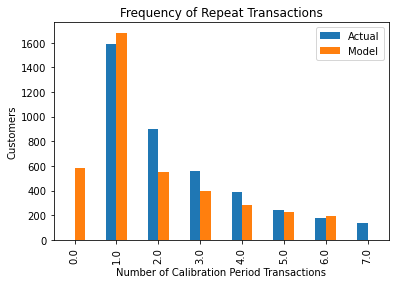

In [18]:
plot_period_transactions(bgf)
plt.show()

In [19]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv_df['frequency'], clv_df['monetary'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.8276,0.0780,3.6748,3.9805
q,0.3470,0.0060,0.3352,0.3588
v,3.6971,0.0789,3.5425,3.8518


In [20]:
clv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(clv_df['frequency'], clv_df['monetary'])

In [21]:
# Customer lifetime value for 1 month:
clv_1M = ggf.customer_lifetime_value(bgf,
                                   clv_df['frequency'],
                                   clv_df['recency'],
                                   clv_df['T'],
                                   clv_df['monetary'],
                                   time=1,  # the lifetime expected for the user in months
                                   freq="M",  # unit of time T is measured.
                                   discount_rate=0.01)

clv_1M.head()


Customer ID
12346.0000     7.9987
12347.0000   615.3514
12348.0000    36.8766
12349.0000   345.6753
12351.0000   208.1279
Name: clv, dtype: float64

In [22]:
clv = clv_1M.reset_index()
clv.sort_values(by="clv", ascending=False).head(10)

,Customer ID,clv
3704,17450.0000,4946.7816
4183,18102.0000,2989.7466
9,12357.0000,2850.5564
1637,14646.0000,2826.3767
3744,17511.0000,2488.6971
2576,15939.0000,2061.7566
3128,16684.0000,2055.4411
50,12415.0000,1993.2381
76,12454.0000,1928.0672
44,12409.0000,1712.6427


In [23]:
clv_final = clv_df.merge(clv, on="Customer ID", how="left")

In [24]:
clv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,num_of_transactions,monetary,expected_average_profit,clv
3704,17450.0000,2.3333,2.5000,3,7,5321.5850,5643.7730,4946.7816
4183,18102.0000,12.4333,12.5000,11,89,3526.4424,3582.3396,2989.7466
9,12357.0000,0.0000,0.8333,1,2,5633.4650,6796.7318,2850.5564
1637,14646.0000,12.0667,12.4667,12,78,3108.7672,3153.9153,2826.3767
3744,17511.0000,12.3000,12.4667,12,31,2726.2206,2765.8515,2488.6971
2576,15939.0000,0.0000,0.3667,1,1,2945.3800,3555.7051,2061.7566
3128,16684.0000,11.7333,12.3000,9,27,2847.7670,2903.2121,2055.4411
50,12415.0000,5.0667,5.4667,4,7,2780.0914,2904.9154,1993.2381
76,12454.0000,0.8333,1.9333,2,4,2811.4450,3075.6579,1928.0672
44,12409.0000,4.8000,6.7333,4,4,3086.6550,3225.1370,1712.6427


<AxesSubplot:xlabel='clv', ylabel='Density'>

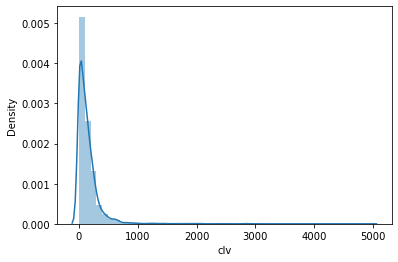

In [25]:
sns.distplot(clv_final['clv'])
